In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load and read the datasets 
athlete_events = pd.read_csv('/Users/mrs.williams/Desktop/Data Science Project 2/archive 2/athlete_events.csv')
noc_regions = pd.read_csv('/Users/mrs.williams/Desktop/Data Science Project 2/archive 2/noc_regions.csv')

# Merge the datasets on the 'NOC' column
merged_data = athlete_events.merge(noc_regions, on='NOC', how='left')

# Check for missing values in the 'region' column
missing_regions = merged_data['region'].isnull().sum()

missing_values = merged_data.isnull().sum()

# Drop irrelevant columns (such as 'notes')
cleaned_data = merged_data.drop(columns=['notes'])

# Handle missing values for 'Medal'
cleaned_data['Medal'] = cleaned_data['Medal'].fillna('No Medal')

# Remove duplicate rows
cleaned_data = cleaned_data.drop_duplicates()

# Standardize text data (lowercase for consistency)
cleaned_data['Sex'] = cleaned_data['Sex'].str.lower()
cleaned_data['Sport'] = cleaned_data['Sport'].str.lower()

# Add a binary column for medal presence
cleaned_data['Medal_Won'] = cleaned_data['Medal'].apply(lambda x: 0 if x == 'No Medal' else 1)

# Check for missing values after cleaning
missing_values_after_cleaning = cleaned_data.isnull().sum()

# Getting mean value depending on the gender
gender_means = cleaned_data.groupby('Sex')[['Height', 'Weight']].mean().round(1)

for gender in cleaned_data['Sex'].unique():
    gender_mask = cleaned_data['Sex'] == gender

    # Fill height
    height_mask = gender_mask & cleaned_data['Height'].isna()
    cleaned_data.loc[height_mask, 'Height'] = gender_means.loc[gender, 'Height']

    # Fill weight
    weight_mask = gender_mask & cleaned_data['Weight'].isna()
    cleaned_data.loc[weight_mask, 'Weight'] = gender_means.loc[gender, 'Weight']

# Round Data to one decimal
cleaned_data[['Height', 'Weight']] = cleaned_data[['Height', 'Weight']].round(1)


print(gender_means)
print()
cleaned_data.head()

     Height  Weight
Sex                
f     167.8    60.0
m     178.9    75.7



,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,Medal_Won
0,1,A Dijiang,m,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,basketball,Basketball Men's Basketball,No Medal,China,0
1,2,A Lamusi,m,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,judo,Judo Men's Extra-Lightweight,No Medal,China,0
2,3,Gunnar Nielsen Aaby,m,24.0,178.9,75.7,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,football,Football Men's Football,No Medal,Denmark,0
3,4,Edgar Lindenau Aabye,m,34.0,178.9,75.7,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,tug-of-war,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,1
4,5,Christine Jacoba Aaftink,f,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,speed skating,Speed Skating Women's 500 metres,No Medal,Netherlands,0


In [3]:
## Converts Male to 1 and Female to 0
le = LabelEncoder()
sex = le.fit_transform(cleaned_data['Sex'])
cleaned_data.drop("Sex", axis=1, inplace=True)
cleaned_data["Sex"] = sex
cleaned_data.head()

,ID,Name,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,Medal_Won,Sex
0,1,A Dijiang,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,basketball,Basketball Men's Basketball,No Medal,China,0,1
1,2,A Lamusi,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,judo,Judo Men's Extra-Lightweight,No Medal,China,0,1
2,3,Gunnar Nielsen Aaby,24.0,178.9,75.7,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,football,Football Men's Football,No Medal,Denmark,0,1
3,4,Edgar Lindenau Aabye,34.0,178.9,75.7,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,tug-of-war,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,1,1
4,5,Christine Jacoba Aaftink,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,speed skating,Speed Skating Women's 500 metres,No Medal,Netherlands,0,0


# Data Exploration

- Q1. Which countries tend to win the most medals, and why?
- Q2. Which sports contribute the most to a country's overall medal count?

In [4]:
medal_per_country = cleaned_data[['region', 'Medal', 'Medal_Won']].copy()
medal_per_country.head()

,region,Medal,Medal_Won
0,China,No Medal,0
1,China,No Medal,0
2,Denmark,No Medal,0
3,Denmark,Gold,1
4,Netherlands,No Medal,0


In [5]:
count_medals = cleaned_data[cleaned_data['Medal_Won'] == 1]['region'].value_counts()
top_countries = count_medals.head(5)
print(top_countries)

region
USA        5637
Russia     3947
Germany    3756
UK         2067
France     1767
Name: count, dtype: int64


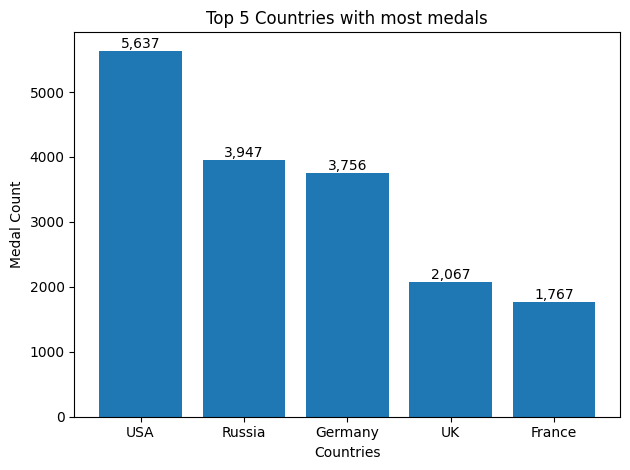

In [6]:
fig, ax = plt.subplots()
plt.title("Top 5 Countries with most medals")
# Assign x and y coordinates
bars = ax.bar(top_countries.index , top_countries.values)

# Add x and y labels
plt.xlabel("Countries")
plt.ylabel("Medal Count")

# Go through each bar and add its value on top of it
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Observations

We can observe that the top 5 countries are mostly countries that are economically powerful, being USA the world power and getting the most amount of medals

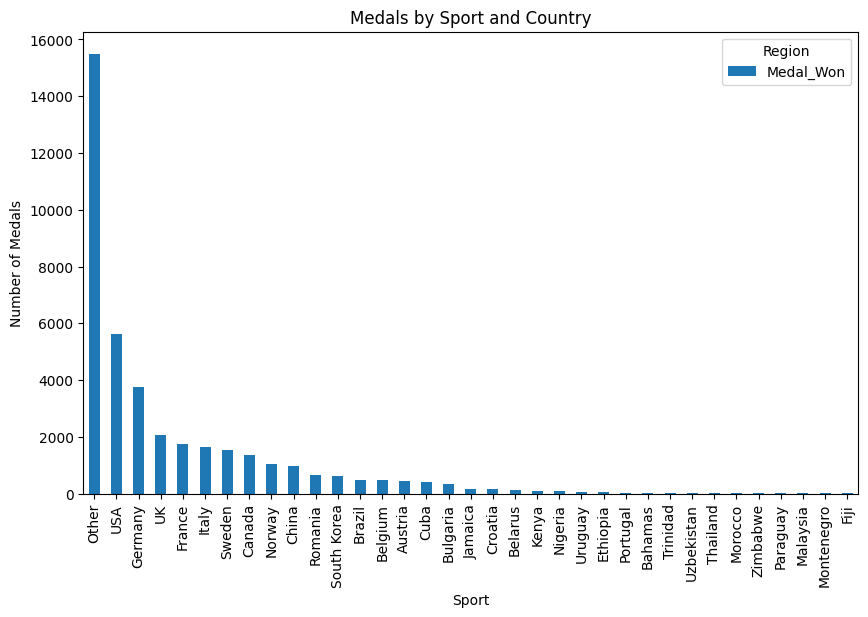

In [7]:
sport_medals = cleaned_data[cleaned_data['Medal_Won'] == 1].groupby(['Sport', 'region'])['Medal_Won'].count().reset_index()

# Grouping regions with less medals than threshold to other
threshold = 10
sport_medals['region'] = sport_medals['region'].apply(lambda x: x if sport_medals[sport_medals['region'] == x]['Medal_Won'].values[0] >= threshold else 'Other')
aggregated = sport_medals.groupby('region')['Medal_Won'].sum().sort_values(ascending=False)
aggregated.plot(kind='bar', figsize=(10,6))
plt.title('Medals by Sport and Country')
plt.ylabel('Number of Medals')
plt.xlabel('Sport')
plt.legend(title='Region')
plt.show()

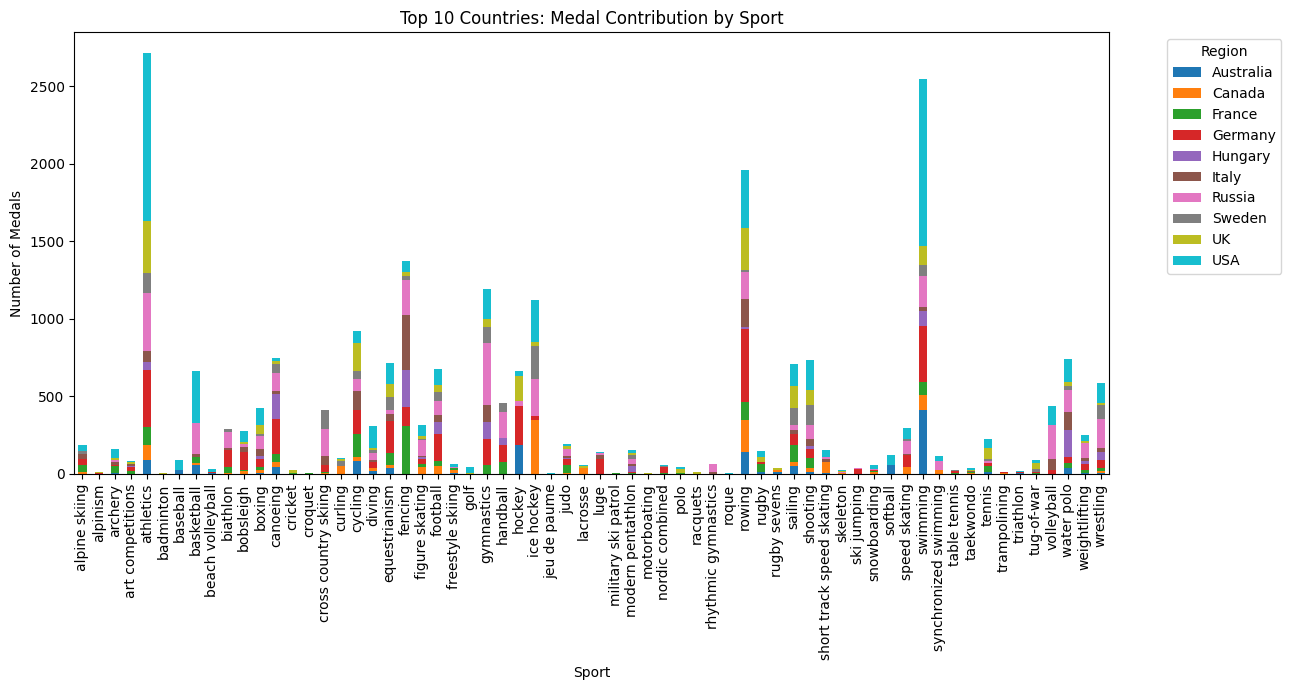

In [8]:
country_medals = cleaned_data[cleaned_data['Medal_Won'] == 1].groupby('region')['Medal_Won'].count().reset_index()
top_countries = country_medals.nlargest(10, 'Medal_Won')['region']

# Filter dataset for top countries
filtered_df = cleaned_data[cleaned_data['region'].isin(top_countries)]

# Re-aggregate by sport and region
filtered_sport_medals = filtered_df[filtered_df['Medal_Won'] == 1].groupby(['Sport', 'region'])['Medal_Won'].count().reset_index()
sport_medals_pivot = filtered_sport_medals.pivot(index='Sport', columns='region', values='Medal_Won').fillna(0)

# Plot
sport_medals_pivot.plot(kind='bar', stacked=True, figsize=(13, 7))
plt.title("Top 10 Countries: Medal Contribution by Sport")
plt.ylabel("Number of Medals")
plt.xlabel("Sport")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

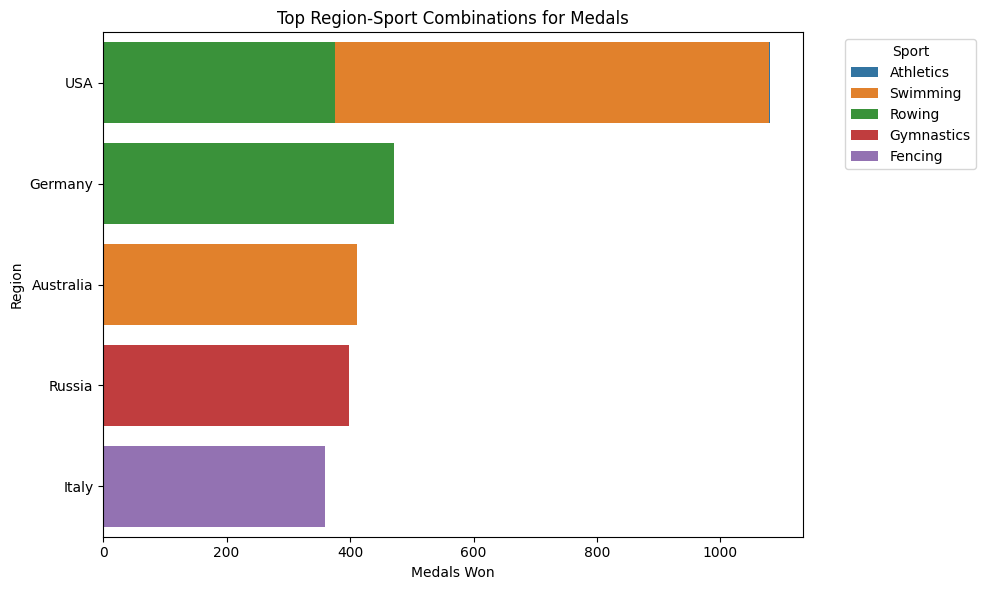

In [9]:
# Data cleaning and preprocessing
merged_data['Medal_Won'] = merged_data['Medal'].notnull().astype(int)  # Binary target: Medal won or not

# Analysis for Most Likely Combination of Country, Region, and Sport
medal_by_region_sport = merged_data.groupby(['region', 'Sport'])['Medal_Won'].sum().reset_index()
top_sport_regions = medal_by_region_sport.sort_values(by='Medal_Won', ascending=False).head(10)

# Visualizing the top region-sport combinations contributing to medals
plt.figure(figsize=(10, 6))
sns.barplot(data=top_sport_regions, x='Medal_Won', y='region', hue='Sport', dodge=False)
plt.title("Top Region-Sport Combinations for Medals")
plt.xlabel("Medals Won")
plt.ylabel("Region")
plt.legend(title="Sport", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

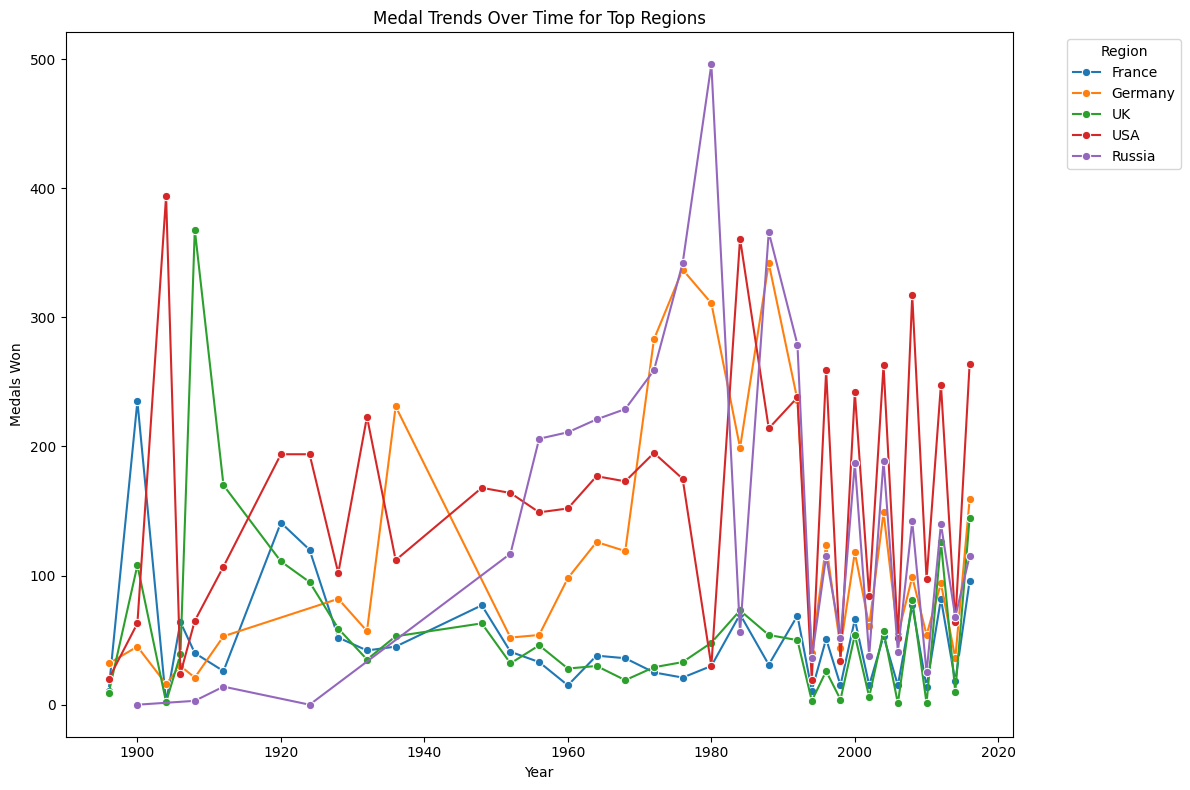

In [10]:
# Analysis for Trends in Medal Counts Over Time
medals_over_time = merged_data.groupby(['Year', 'region'])['Medal_Won'].sum().reset_index()

# Selecting top regions for visualization
top_regions = medals_over_time.groupby('region')['Medal_Won'].sum().nlargest(5).index
medals_over_time_filtered = medals_over_time[medals_over_time['region'].isin(top_regions)]

# Plot trends over time for top regions
plt.figure(figsize=(12, 8))
sns.lineplot(data=medals_over_time_filtered, x='Year', y='Medal_Won', hue='region', marker='o')
plt.title("Medal Trends Over Time for Top Regions")
plt.xlabel("Year")
plt.ylabel("Medals Won")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
from scipy.stats import ttest_ind

# Hosting Influence on Medal Counts
host_years = {2020: 'Japan', 2016: 'Brazil', 2012: 'United Kingdom', 2008: 'China'}  # Example years
merged_data['Is_Host'] = merged_data.apply(
    lambda row: 1 if row['Year'] in host_years and row['region'] == host_years[row['Year']] else 0, axis=1)

# Compare medal counts for hosting vs. non-hosting years
hosting_medals = merged_data.groupby(['region', 'Is_Host'])['Medal_Won'].sum().reset_index()

# Perform a statistical test
host_medals = hosting_medals[hosting_medals['Is_Host'] == 1]['Medal_Won']
non_host_medals = hosting_medals[hosting_medals['Is_Host'] == 0]['Medal_Won']
t_stat, p_value = ttest_ind(host_medals, non_host_medals, nan_policy='omit')

# Print statistical test results
print("Hosting Influence on Medals:")
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

Hosting Influence on Medals:
T-statistic: -0.17, P-value: 0.8644


The t-statistic measures the difference in means between the two groups, hosting vs non-hosting countires and the p-value represent the probability that the observed difference in the means occurred due to random chance. The t-statistic of -0.17 suggest that there is no significant difference in the average medal counts and the high p-value suggest that there is no evidence to support that the hosting country influences a country's count.

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     69407
           1       0.27      0.35      0.30     11928

    accuracy                           0.77     81335
   macro avg       0.58      0.59      0.58     81335
weighted avg       0.79      0.77      0.78     81335

Confusion Matrix:
[[58342 11065]
 [ 7803  4125]]


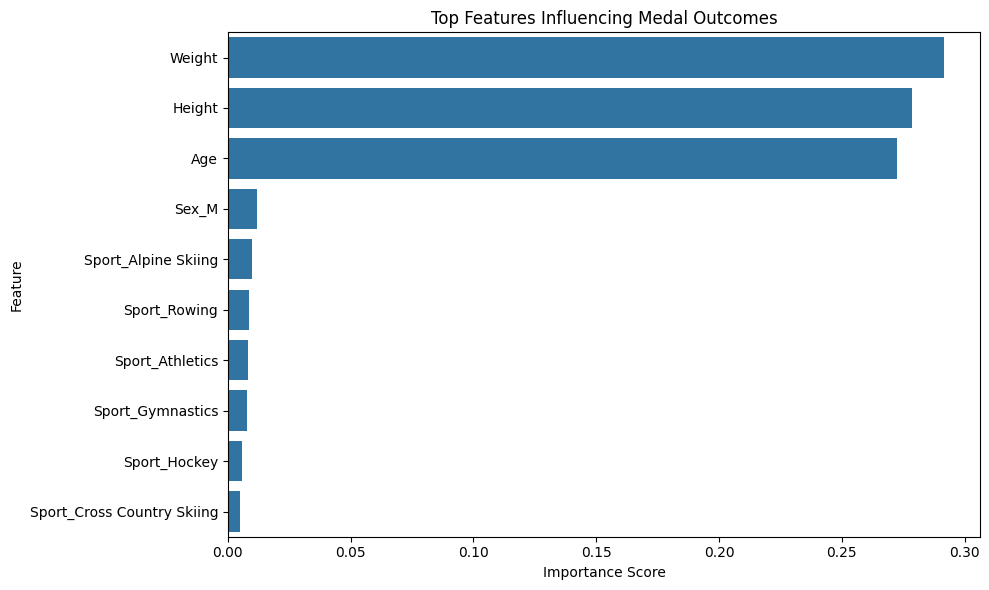

In [12]:
# Analysis for Factors Influencing Medal Outcomes
# Feature engineering for predictive modeling
features = ['Age', 'Height', 'Weight', 'Sex', 'Sport']
encoded_data = pd.get_dummies(merged_data[features], drop_first=True)
X = encoded_data
y = merged_data['Medal_Won']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Plot feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature')
plt.title("Top Features Influencing Medal Outcomes")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The model performs well for the No Medal class with high precision and recall but struggles with the Medal won class. This model is also biased toward predicitng No Medal since it has a much larger support.

In [13]:
# Analysis for Predicting Specific Event Outcomes
# Focus on a single sport
swimming_data = merged_data[merged_data['Sport'] == 'Swimming']

# Prepare features and target
features = ['Age', 'Height', 'Weight', 'Sex']
encoded_swimming_data = pd.get_dummies(swimming_data[features], drop_first=True)
X_swimming = encoded_swimming_data
y_swimming = swimming_data['Medal_Won']

# Split data for swimming
X_train_swim, X_test_swim, y_train_swim, y_test_swim = train_test_split(X_swimming, y_swimming, test_size=0.3, random_state=42)

# Train LightGBM for swimming
from lightgbm import LGBMClassifier
lgbm_model_swim = LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, class_weight='balanced', random_state=42)
lgbm_model_swim.fit(X_train_swim, y_train_swim)

# Evaluate the LightGBM model for swimming
y_pred_swim = lgbm_model_swim.predict(X_test_swim)
print("LightGBM Classification Report for Swimming:")
print(classification_report(y_test_swim, y_pred_swim))
print("Confusion Matrix for Swimming:")
print(confusion_matrix(y_test_swim, y_pred_swim))

[LightGBM] [Info] Number of positive: 2132, number of negative: 14104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 16236, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

This model shows that No Medal has more support compared to Medal Won support of 916 instances making the peformance skewed. Just like the Random Forest, the Light GBM struggles to correctly classify Medal Won but performs well at identifying No Medal instances. But the recall of 60% indictaes that the model captures more actual Medal Won instances than randomly guessing.